## <div style="color:red"> Bab 1 : Problem Statement </div>

#### Masalah
- Awal maret, Indonesia dikejutkan dengan covid-19 yang mulai mulai masuk dengan data 2 orang yang terindikasi terkena covid.
- Pada penelitian kali ini, peneliti akan melihat pada hari keberapa kemungkinan akan terjadinya lonjakan tertinggi kasus covid-19 dan apa yang terjadi jika diberikan perlakuan seperti *social distancing*. Apakah akan membuat lonjakannya menurun/tidak?

#### Model yang digunakan pada data modelling kali ini adalah menggunakan SIR (Susceptible, Infectious, Recovered)
- model SIR ini pertama kali digunakan untuk melihat dinamika penyebaran populasi akibat penyakit menular. Pengembangan dari SIR ini adalah SIRS, SIRD, dll. 
- untuk pengolahan kali ini : S(pasien yg rentan), I(pasien yg sudah dan sedang terkena), R(pasien yg sembuh)
- β : laju S ke I (laju penyebaran covid),  γ : laju I ke R (laju kesembuhan)
- Batasan :
  1. Pada penelitian ini adalah kita tidak melihat laju kematian. Dengan begitu, kematian dan kelahiran dianggap konstan.
  2. Pasien yang terkena covid dianggap tidak terinfeksi covid kembali
![Main page preview](SIR.png)

## <div style="color:red">Bab 2 : Data Cleaning and Preprocessing</div>

In [1]:
# library needed 
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [33]:
# source Jakarta
df = pd.read_excel("Daily Update Data Agregat Covid-19 Jakarta.xlsx", sheet_name="Data Jakarta")

In [34]:
df.head()

,Tanggal,Jam,Tanggal Jam,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian,Tanpa Gejala,Bergejala,Belum Ada Data
0,2020-03-01,NaN,NaN,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,2020-03-02,NaN,NaN,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,2020-03-03,NaN,NaN,1,0,0,2,3,3,2,0,NaN,NaN,NaN
3,2020-03-04,NaN,NaN,1,0,0,2,3,0,2,0,NaN,NaN,NaN
4,2020-03-05,NaN,NaN,3,0,0,4,7,4,4,0,NaN,NaN,NaN


In [35]:
df.tail()

,Tanggal,Jam,Tanggal Jam,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian,Tanpa Gejala,Bergejala,Belum Ada Data
854,2022-07-03,NaN,NaN,15320,1248357,8333,745,1272755,931,9078,1213,0.0,18.0,9060.0
855,2022-07-04,NaN,NaN,15323,1249496,7937,736,1273492,737,8673,1139,0.0,14.0,8659.0
856,2022-07-05,NaN,NaN,15325,1250388,8267,788,1274768,1276,9055,892,0.0,52.0,9003.0
857,2022-07-06,NaN,NaN,15327,1251237,8946,774,1276284,1516,9720,849,0.0,53.0,9667.0
858,2022-07-07,NaN,NaN,15329,1252398,9220,813,1277760,1476,10033,1161,0.0,68.0,9965.0


In [36]:
df.shape

(859, 14)

In [37]:
# cek tiap kolom apakah ada yang kosong 
df.isna().any()

Tanggal            False
Jam                 True
Tanggal Jam         True
Meninggal          False
Sembuh             False
Self Isolation     False
Masih Perawatan    False
Total Pasien       False
Positif Harian     False
Positif Aktif      False
Sembuh Harian      False
Tanpa Gejala        True
Bergejala           True
Belum Ada Data      True
dtype: bool

In [38]:
# hapus empty column Jam dan Tanggal jam dikarenakan semua NaN
df.dropna(how='all', axis=1, inplace=True)
  
# show the dataframe
display(df)

,Tanggal,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian,Tanpa Gejala,Bergejala,Belum Ada Data
0,2020-03-01,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,2020-03-02,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,2020-03-03,1,0,0,2,3,3,2,0,NaN,NaN,NaN
3,2020-03-04,1,0,0,2,3,0,2,0,NaN,NaN,NaN
4,2020-03-05,3,0,0,4,7,4,4,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
854,2022-07-03,15320,1248357,8333,745,1272755,931,9078,1213,0.0,18.0,9060.0
855,2022-07-04,15323,1249496,7937,736,1273492,737,8673,1139,0.0,14.0,8659.0
856,2022-07-05,15325,1250388,8267,788,1274768,1276,9055,892,0.0,52.0,9003.0
857,2022-07-06,15327,1251237,8946,774,1276284,1516,9720,849,0.0,53.0,9667.0


In [41]:
# Mengganti NaN pada (Tanpa Gejala, Bergejala, Belum Ada Data) dengan 0
dat = df.fillna(0)
dat

,Tanggal,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian,Tanpa Gejala,Bergejala,Belum Ada Data
0,2020-03-01,0,0,0,0,0,0,0,0,0.0,0.0,0.0
1,2020-03-02,0,0,0,0,0,0,0,0,0.0,0.0,0.0
2,2020-03-03,1,0,0,2,3,3,2,0,0.0,0.0,0.0
3,2020-03-04,1,0,0,2,3,0,2,0,0.0,0.0,0.0
4,2020-03-05,3,0,0,4,7,4,4,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
854,2022-07-03,15320,1248357,8333,745,1272755,931,9078,1213,0.0,18.0,9060.0
855,2022-07-04,15323,1249496,7937,736,1273492,737,8673,1139,0.0,14.0,8659.0
856,2022-07-05,15325,1250388,8267,788,1274768,1276,9055,892,0.0,52.0,9003.0
857,2022-07-06,15327,1251237,8946,774,1276284,1516,9720,849,0.0,53.0,9667.0


In [44]:
# data row 0-1 kosong jadi perlu di hapus
dat= dat.drop([0,1]);
dat

,Tanggal,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian,Tanpa Gejala,Bergejala,Belum Ada Data
2,2020-03-03,1,0,0,2,3,3,2,0,0.0,0.0,0.0
3,2020-03-04,1,0,0,2,3,0,2,0,0.0,0.0,0.0
4,2020-03-05,3,0,0,4,7,4,4,0,0.0,0.0,0.0
5,2020-03-06,3,0,0,4,7,0,4,0,0.0,0.0,0.0
6,2020-03-07,3,0,0,4,7,0,4,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
854,2022-07-03,15320,1248357,8333,745,1272755,931,9078,1213,0.0,18.0,9060.0
855,2022-07-04,15323,1249496,7937,736,1273492,737,8673,1139,0.0,14.0,8659.0
856,2022-07-05,15325,1250388,8267,788,1274768,1276,9055,892,0.0,52.0,9003.0
857,2022-07-06,15327,1251237,8946,774,1276284,1516,9720,849,0.0,53.0,9667.0


In [45]:
# Print a brief summary of the DataFrame
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857 entries, 2 to 858
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Tanggal          857 non-null    datetime64[ns]
 1   Meninggal        857 non-null    int64         
 2   Sembuh           857 non-null    int64         
 3   Self Isolation   857 non-null    int64         
 4   Masih Perawatan  857 non-null    int64         
 5   Total Pasien     857 non-null    int64         
 6   Positif Harian   857 non-null    int64         
 7   Positif Aktif    857 non-null    int64         
 8   Sembuh Harian    857 non-null    int64         
 9   Tanpa Gejala     857 non-null    float64       
 10  Bergejala        857 non-null    float64       
 11  Belum Ada Data   857 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 87.0 KB


In [46]:
# cek data kosong
dat.isna().any()

Tanggal            False
Meninggal          False
Sembuh             False
Self Isolation     False
Masih Perawatan    False
Total Pasien       False
Positif Harian     False
Positif Aktif      False
Sembuh Harian      False
Tanpa Gejala       False
Bergejala          False
Belum Ada Data     False
dtype: bool

In [47]:
# cek data duplicate
bool_series = dat.duplicated()
bool_series 

2      False
3      False
4      False
5      False
6      False
       ...  
854    False
855    False
856    False
857    False
858    False
Length: 857, dtype: bool

## <div style="color:red">Bab 3 : Exploratory Data Analysis</div>  

In [48]:
korelasi = dat.corr()
korelasi
# terdapat hubungan erat antara positif aktif, positif harian terhadap self isolation
# nantii hipotesanya : self isolation --> mengganggu mobilitas
# mohon dicek : apa yang bergejala & bergejala ini trennya naik atau tidak
# cek : self isolation, masih perawatan, positif harian, positif aktif, sembuh harian, belum ada data

,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian,Tanpa Gejala,Bergejala,Belum Ada Data
Meninggal,1.000000,0.982930,0.139234,0.018215,0.983890,0.148909,0.112608,0.169768,-0.328570,-0.181455,0.299282
Sembuh,0.982930,1.000000,0.113432,-0.032116,0.999049,0.111829,0.080264,0.149366,-0.344389,-0.222814,0.284857
Self Isolation,0.139234,0.113432,1.000000,0.887200,0.156261,0.927753,0.993622,0.836859,0.422301,0.636004,0.851936
Masih Perawatan,0.018215,-0.032116,0.887200,1.000000,0.009045,0.891232,0.933568,0.734468,0.447984,0.742443,0.717830
Total Pasien,0.983890,0.999049,0.156261,0.009045,1.000000,0.152426,0.123593,0.184880,-0.323815,-0.192129,0.320055
Positif Harian,0.148909,0.111829,0.927753,0.891232,0.152426,1.000000,0.938486,0.791719,0.318543,0.550823,0.858726
Positif Aktif,0.112608,0.080264,0.993622,0.933568,0.123593,0.938486,1.000000,0.829568,0.437526,0.675495,0.837213
Sembuh Harian,0.169768,0.149366,0.836859,0.734468,0.184880,0.791719,0.829568,1.000000,0.275716,0.468009,0.765921
Tanpa Gejala,-0.328570,-0.344389,0.422301,0.447984,-0.323815,0.318543,0.437526,0.275716,1.000000,0.785969,0.112552
Bergejala,-0.181455,-0.222814,0.636004,0.742443,-0.192129,0.550823,0.675495,0.468009,0.785969,1.000000,0.211156


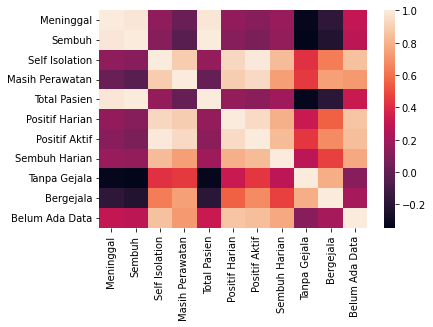

In [49]:
sns.heatmap(korelasi);

## Penjelasan
![Korelasi](korelasi.jpg)
- "Positif Harian", "Positif Aktif" menunjukkan korelasi tinggi dengan "Self Isolation". 
- "Total Pasien", "Total Pasien" menunjukan korelasi tinggi dengan "sembuh" dan "meninggal" karena pasien memiliki kemungkinana sembuh atau meninggal 
-"Positif Aktif" memiliki korelasi yang lebih tinggi degan "bergejala" dibanding "tanpa gejala"

<Figure size 432x288 with 0 Axes>

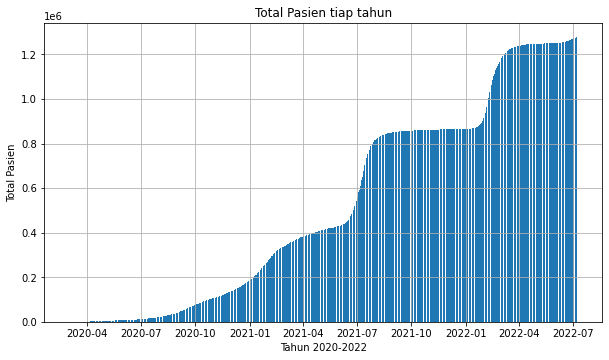

In [50]:
plt.clf()
fig, ax = plt.subplots(figsize=(10,5.5))
plt.xlabel('Tahun 2020-2022')
plt.ylabel('Total Pasien')

plt.title('Total Pasien tiap tahun')
ax.bar(data=dat, x='Tanggal', height='Total Pasien')
plt.grid(True)
plt.show()

## Penjelasan
- TOTAL PASIEN meningkat dengan alur LAMBAT di AWAL, tetapi mulai CEPAT di SEKITAR bulan September 2021
- Terdapat dua LONJAKAN pada TOTAL PASIEN, yaitu PERTAMA di SEKITAR bulan Juli 2021 dan KEDUA di SEKITAR bulan Maret 2022
- Setelah LONJAKAN akan ada waktu saat TOTAL PASIEN BERTAMBAH secara LAMBAT

<Figure size 432x288 with 0 Axes>

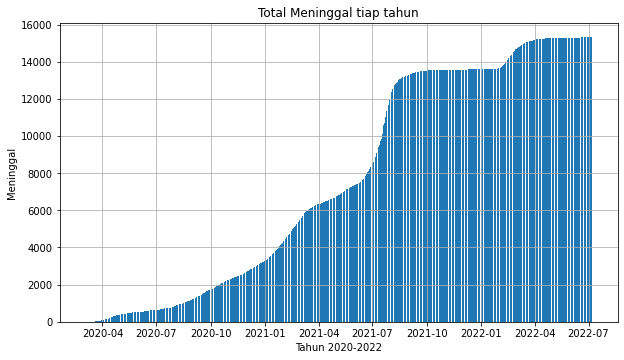

In [51]:
plt.clf()
fig, ax = plt.subplots(figsize=(10,5.5))
plt.xlabel('Tahun 2020-2022')
plt.ylabel('Meninggal')

plt.title('Total Meninggal tiap tahun')
ax.bar(data=dat, x='Tanggal', height='Meninggal')
plt.grid(True)
plt.show()

## Penjelasan
- Dari grafik terlihat di atas terlihat ada gradien yang memiliki kemiringan tinggi ini berarti lonjakan kematian tertinggi terjadi pada bulan Juli 2021 hingga Sepetember 2021.

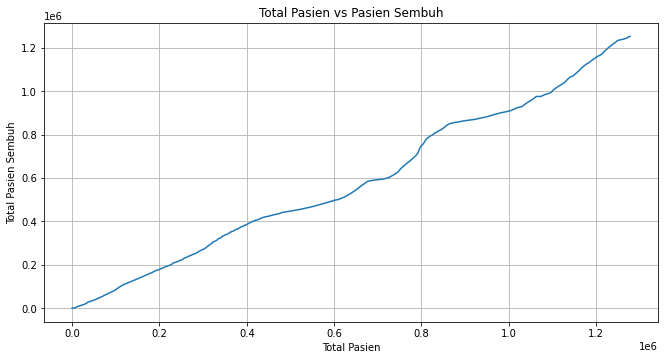

In [52]:
plt.rcParams["figure.figsize"] = (11,5.5)

x = list(dat['Total Pasien'])
y= list(dat['Sembuh'])
plt.plot(x,y)

plt.xlabel('Total Pasien')
plt.ylabel('Total Pasien Sembuh')

plt.title('Total Pasien vs Pasien Sembuh')
plt.grid(True)

plt.show()


## Penjelasan 
- Tingkat kemungkinan SEMBUH hampir setara dengan TOTAL PASIEN sehingga menandakan kemungkinan SEMBUH sangat besar karena kurva menunjukan gradien hampir 45 derajat sempurna

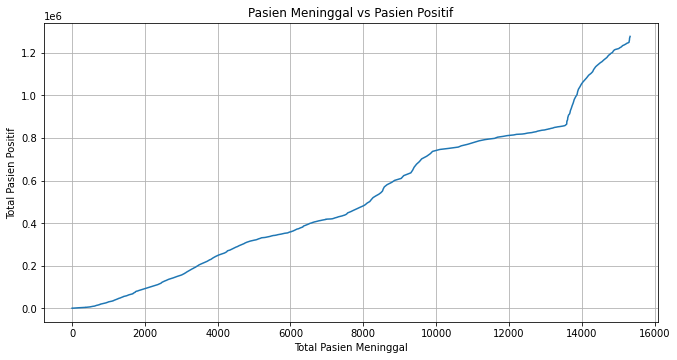

In [53]:
plt.rcParams["figure.figsize"] = (11,5.5)

x = list(dat['Meninggal'])
y= list(dat['Total Pasien'])
plt.plot(x,y)

plt.xlabel('Total Pasien Meninggal')
plt.ylabel('Total Pasien Positif')

plt.title('Pasien Meninggal vs Pasien Positif')
plt.grid(True)

plt.show()

## Penjelasan
- Pada awalnya semakin BANYAK pasien POSITIF maka semakin BANYAK pasien MENINGGAL
- Namun, saat kasus MENINGGAL sekitar 14.000 (Kemungkinan GELOMBANG yang terjadi tidak mematikan atau infrastruktur kesehatan telah memadai) KEMATIAN semakin SEDIKIT walaupun POSITIF semakin BANYAK.
- Dapat terlihat dua kemungkinan GELOMBANG, yaitu saat kasus meninggal 12.000 dan kasus meninggal 14.000. GELOMBANG PERTAMA terjadi 12.000 kasus kematian akibat varian DELTA sedangkan GELOMBANG KEDUA akibat varian OMICRON karena terdapat banyak pasien yang SEMBUH

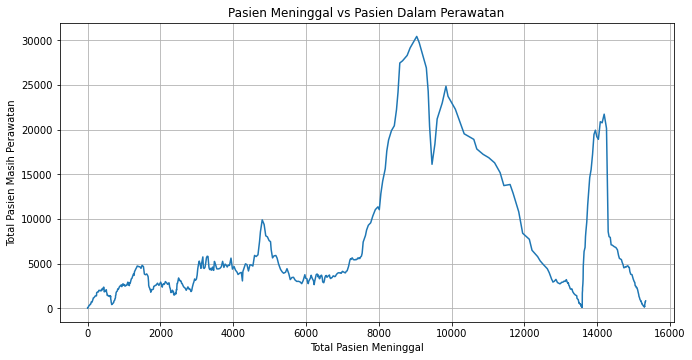

In [54]:
plt.rcParams["figure.figsize"] = (11,5.5)

x = list(dat['Meninggal'])
y= list(dat['Masih Perawatan'])
plt.plot(x,y)

plt.xlabel('Total Pasien Meninggal')
plt.ylabel('Total Pasien Masih Perawatan')

plt.title('Pasien Meninggal vs Pasien Dalam Perawatan')
plt.grid(True)

plt.show()

## Penjelasan
1. Semakin banyak PASIEN DALAM PERAWATAN maka PERTAMBAHAN KEMATIAN akan semakin BERKURANG. Hal ini kemungkinan dikarenakan oleh kebijakan seperti pemberian vaksin untuk meningkatkan imunitas.
2. Terlihat pada grafik, terdapat gradien yang curam di saat total kematian 14.000 yang menandakan pasien MENINGGAL lebih SEDIKIT dibanding gradien yang tidak curam di saat total kematian 10.000 hingga hampir 14.000

In [55]:
# Summary data
dat.describe()
# didapat?

,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian,Tanpa Gejala,Bergejala,Belum Ada Data
count,857.000000,8.570000e+02,857.000000,857.000000,8.570000e+02,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000
mean,7700.759627,5.062412e+05,9102.583431,3415.969662,5.264605e+05,1490.968495,12518.553092,1461.374562,3016.124854,4086.577596,6480.653442
std,5790.480747,4.411524e+05,15078.788577,4744.150133,4.488291e+05,2515.387966,19411.602519,2736.567668,5683.016440,7414.412981,14147.781055
min,1.000000,0.000000e+00,0.000000,2.000000,3.000000e+00,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,1743.000000,6.328600e+04,1381.000000,534.000000,7.778400e+04,132.000000,2379.000000,127.000000,0.000000,0.000000,521.000000
50%,6830.000000,3.986100e+05,4289.000000,2178.000000,4.124180e+05,686.000000,7057.000000,624.000000,55.000000,79.000000,1405.000000
75%,13579.000000,8.502280e+05,8801.000000,3970.000000,8.641780e+05,1425.000000,12440.000000,1294.000000,3776.000000,5810.000000,5207.000000
max,15329.000000,1.252398e+06,88295.000000,30418.000000,1.277760e+06,15825.000000,113138.000000,20570.000000,35311.000000,60476.000000,88873.000000


In [56]:
dat['Meninggal'].max()

15329

## Penjelasan
Total pasien covid yang meninggal di Jakarta adalah sebanyak 15.329 

In [57]:
dat['Sembuh'].max()


1252398

## Penjelasan
Total Pasien yang sembuh adalah 1.252.398 orang 

In [58]:
# Rata rata positif harian
round(dat['Positif Harian'].mean())


1491

## Penjelasan
Ada sekitar 1.487 orang terkena covid-19 setiap harinya di jakarta di dari bulan Maret 2020- Juli 2022

In [59]:
# cek data terakhir untuk mengukur mortality rate terakhir
dat.tail()

,Tanggal,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian,Tanpa Gejala,Bergejala,Belum Ada Data
854,2022-07-03,15320,1248357,8333,745,1272755,931,9078,1213,0.0,18.0,9060.0
855,2022-07-04,15323,1249496,7937,736,1273492,737,8673,1139,0.0,14.0,8659.0
856,2022-07-05,15325,1250388,8267,788,1274768,1276,9055,892,0.0,52.0,9003.0
857,2022-07-06,15327,1251237,8946,774,1276284,1516,9720,849,0.0,53.0,9667.0
858,2022-07-07,15329,1252398,9220,813,1277760,1476,10033,1161,0.0,68.0,9965.0


In [60]:
# mortality rate 
mortality_rate = dat.at[858,'Meninggal']/dat.at[858,'Total Pasien']
mortality_rate*100


1.1996775607312797

## Penjelasan
Mortality rate pada update terakhir data ini adalah sebesar 1,19 %

In [61]:
# Recovery rate
recovery_rate = dat.at[858,'Sembuh']/dat.at[858,'Total Pasien']
recovery_rate*100

98.01512021036814

# Penjelasan 
Recovery rate pada update data terakhir adalah 98.01%. Hal ini menunjukkan bahwa kebijakan pemerintah cukup berhasil menekan angka kematian sampai sekecil-kecilnya sehingga harapan hidup dari pasien yang terjangkit covid sangat besar.  

## <div style="color:red"> BAB 4 : Modelling </div>

C:\Users\niman\AppData\Local\Temp\ipykernel_59036\117074367.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


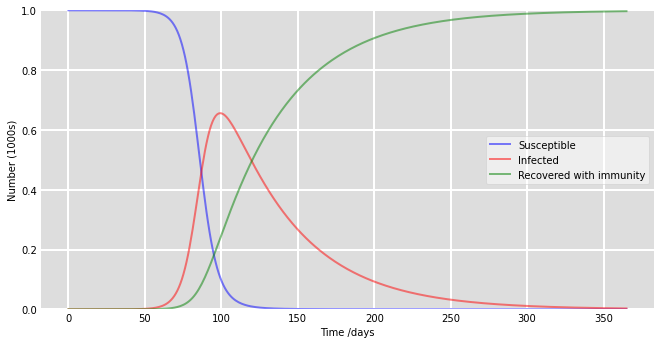

In [62]:
# TAHAPAN PEMODELAN 

# Total population, -> penduduk jakarta sekitar 1 juta orang
N = 10000000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 2, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 9994/(15707*30) 
# A grid of time points (in days)
t = np.linspace(0, 365, 365)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show();

## Penjelasan
- Berdasarkan prediksi dari model SIR yang telah dicoba, peneliti memprediksi gelombang tertinggi kasus covid-19 akan terjadi pada hari ke-100 semenjak kemunculannya pada bulan Maret 2020. 
- Model diatas ini adalah prediksi gambaran sederhana tentang gelombang Covid-19 dengan anggapan tidak diberikannya perlakuan khusus/parameter yang dilakukan untuk mencegah Covid-19.

C:\Users\niman\AppData\Local\Temp\ipykernel_59036\4249779233.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


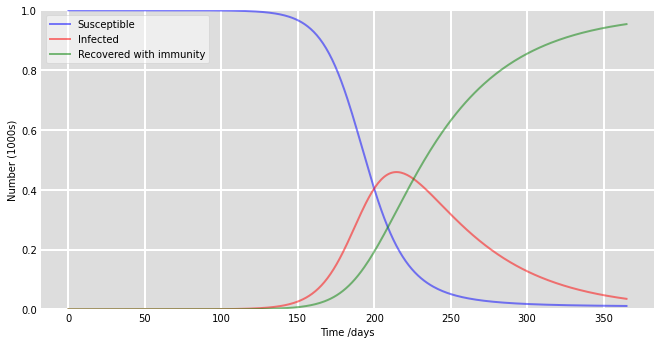

In [63]:
## jika diberikan parameter rho sebagai parameter. rho : perlakuan seperti social distancing

# Total population, -> penduduk jakarta sekitar 10 juta orang
N = 10000000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 2, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma,rho = 0.2, 9994/(15707*30),0.5
# A grid of time points (in days)
t = np.linspace(0, 365, 365)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma,rho):
    S, I, R = y
    dSdt = -beta *rho* S * I / N
    dIdt = beta *rho * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, rho))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Penjelasan
- Pada model prediksi diatas, diberikan parameter baru berupa Rho(ρ). ρ adalah perlakuan khusus yang diberikan untuk menekan penyebaran covid-19 ke populasi yang rentan seperti kebijakan social distancing. ρ bernilai antar 0-1. Pada penelitian ini, peneliti menganggap efek social distancing ini memberikan efek yang cukup sebesar 0,5 dari skala 0-1.  
- Setelah diberikannya parameter ρ, peneliti memprediksi gelombang tertinggi kasus covid-19 akan terjadi setelah hari ke-200 dan gelombang tertingginya lebih rendah daripada tidak diberikan parameter ρ .

## <div style="color:red">Kesimpulan</div> 

- Dengan melakukan analisis dengan metode SIR sehinga didapatkan bahwa gelombang pertama Covid-19 yang terjadi pada pertengahan tahun 2021 memiliki tingkat infeksi yang tinggi dengan tingkat kematian yang tinggi hal ini dapat dilihat pada grafik di atas yang menggambarkan lonjakan pasien Covid-19 beserta peningkatan jumlah kematian yang sangat tinggi di bulan Juli 2021 hingga Sepetember 2021.
- Gelombang kedua yang terjadi pada awal quartal 2022 memiliki tingkat infeksi yang lebih tinggi dari tahun sebelumnya tetapi memiliki tingkat kematian yang lebih rendah.
- Jumlah kematian yang semakin menurun dari gelombang yang sebelumnya dapat dilihat dari grafik hasil analisis di atas yang menunjukan semakin curam grafik maka angka kematian semakin sedikit dan berlaku sebaliknya.
- Namun seiring berjalannya waktu total pasien yang terjangkit Covid-19 memiliki gradien hampir sempurna 45 derajat dengan pasien yang sembuh sehingga itu berarti hampir semua pasien yang terjangkit memiliki peluang sembuh yang tinggi.
- Peneliti menyarankan berdasarkan hasil data percobaan diatas bahwa kebijakan social distancing dan tindakan pencegahan penyebaran virus lainnya perlu diberlakukan sebelum H-100 setelah kejadian pertama agar memberikan pengaruh yang efektif.

## <div style="color:red">Daftar Pusataka</div> 
1. Cooper, I., Mondal, A. and Antonopoulos, C.G., 2020. A SIR model assumption for the spread of COVID-19 in different communities. Chaos, Solitons & Fractals, 139, p.110057.
2. https://tiny.cc/Datacovidjakarta